<a href="https://colab.research.google.com/github/GermanOmar/ANN1/blob/main/WAAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep neural network process model for Wire + Arc Additive Manufacturing (WAAM) 

In [1]:
!pip install -U tensorflow-addons


     |████████████████████████████████| 1.1MB 11.8MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from sklearn.ensemble import BaggingRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

#EXPERIMENTAL DATASET:



In [5]:
dataE = pd.read_table('dataExp.txt') 
dataE.describe()

,r,theta,EWW,Lc,aWD,Qp
count,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000
mean,3.748000,0.462800,7.254000,1.200000e+00,4.556000,1.421360
std,0.494233,0.124181,1.072369,4.532467e-16,0.396947,0.351795
min,2.900000,0.270000,5.440000,1.200000e+00,3.900000,0.889000
25%,3.400000,0.380000,6.450000,1.200000e+00,4.300000,1.207000
50%,3.700000,0.440000,7.170000,1.200000e+00,4.500000,1.343000
75%,4.000000,0.550000,7.860000,1.200000e+00,4.800000,1.552000
max,4.800000,0.720000,9.410000,1.200000e+00,5.400000,2.298000


<a href="https://ibb.co/QrLn5c3"><img src="https://i.ibb.co/XS1pw4r/FIG1-geo.png" WIDTH="500" HEIGHT="325"  border="0"></a>

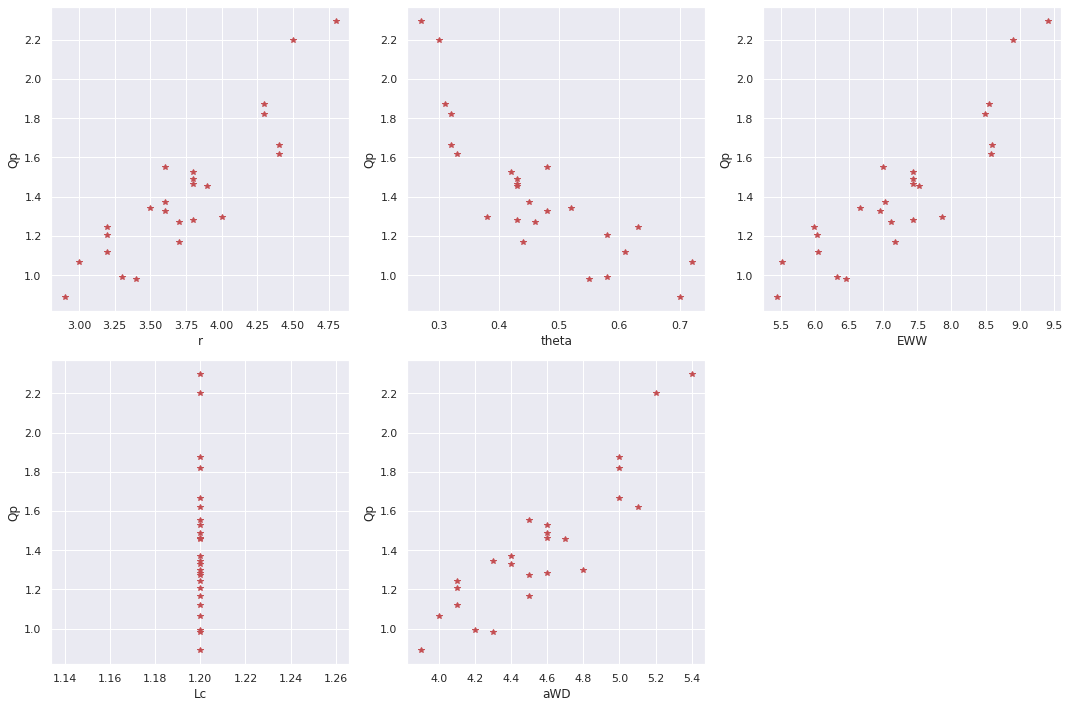

In [6]:
fields2 = ['r', 'theta', 'EWW', 'Lc', 'aWD']

fig = plt.figure()
fig.set_size_inches((15,10))
for i, field2 in enumerate(fields2):
  plt.subplot(2, 3, i + 1)
  plt.plot(dataE[field2], dataE['Qp'], 'r*')
  plt.xlabel(field2)
  plt.ylabel('Qp')

plt.tight_layout()

#Well`s Model:

Here, we compute the equation (1):
$$ Q^* = 4k*   EWW*  (T_m - T_o)*( \frac{1}{5} + \frac{aWD}{L_c})  $$
Were:
$$L_c = \frac{2 \alpha}{TS} $$.

In [3]:
#Load Dataset from the model
data = pd.read_table('dataWells.txt') 
data.describe()


,r,theta,EWW,Lc,aWD,Qp
count,231.000000,231.000000,231.000000,2.310000e+02,231.000000,231.000000
mean,3.850000,0.453550,7.503333,1.200000e+00,4.654017,1.498134
std,0.668281,0.165433,1.438930,5.118116e-15,0.523173,0.439413
min,2.700000,0.240000,4.930000,1.200000e+00,3.752000,0.786000
25%,3.275000,0.310000,6.285000,1.200000e+00,4.205000,1.116000
50%,3.850000,0.410000,7.540000,1.200000e+00,4.651000,1.474000
75%,4.425000,0.570000,8.740000,1.200000e+00,5.103500,1.868500
max,5.000000,0.840000,9.930000,1.200000e+00,5.557000,2.302000


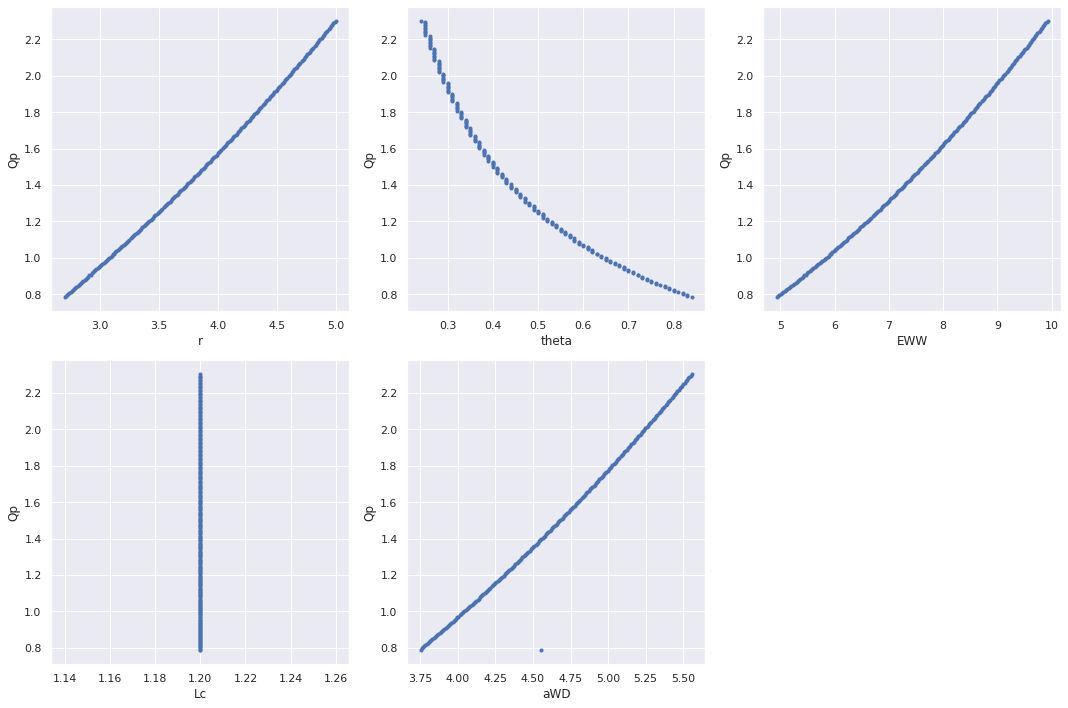

In [4]:
fields = ['r', 'theta', 'EWW', 'Lc', 'aWD']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,10))
for i, field in enumerate(fields):
  plt.subplot(2, 3, i + 1)
  plt.plot(data[field], data['Qp'], 'b.')
  plt.xlabel(field)
  plt.ylabel('Qp')

plt.tight_layout()

#Setting inputs - output:

In [7]:
X=data[['r', 'theta', 'EWW', 'Lc', 'aWD']]
Y=data['Qp'][:,None]

XE=dataE[['r', 'theta', 'EWW', 'Lc', 'aWD']]
YE=dataE['Qp'][:,None]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


#Normalizing:

In [8]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu


X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

# Split data

In [9]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.19, random_state=42)
#print('training samples:', X_train.shape[0], ' validation samples:', X_val.shape[0], ' test samples:', X_test.shape[0])
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 184  test samples: 47


#Setting hyperparameters:

In [10]:
width = 12
depth = 12
L2 = 0.001

#net_input = Input(shape=(Xn.shape[1],),name='input')
net_input = Input(shape=(X.shape[1],),name='input')

#net_output = Sequential([Dense(width, 'relu')]*(depth - 1) + [Dense(1, 'linear')], name = 'base_NN')(net_input)
net_output = Sequential([Dense(width, 'relu', kernel_regularizer=regularizers.l2(L2))]*(depth - 1) + [Dense(1, 'linear', kernel_regularizer=regularizers.l2(L2))], name = 'base_NN')(net_input) 
#net_output = Sequential([Dense(width, 'relu')]*(depth - 1) + [Dense(1, 'linear')], name = 'base_NN')(net_input) 


model = Model(inputs=net_input, outputs=net_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

#Training:

In [11]:
#callback = EarlyStopping(monitor='val_loss', patience=100)
#history = model.fit(X_train, y_train, epochs=4000, batch_size = 6, validation_data= (X_val, y_val), callbacks = [tqdm_callback], verbose = 3)
history = model.fit(X_train, y_train, epochs=2000, batch_size = 10, validation_data= (X_test, y_test), verbose = 3)

Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2000
Epoch 69/2000
Epoch 70/2000
Epoch 71/2000
Epoch 72/2000
E

#Testing:

MSE train: 0.000501483012415426
MSE test: 0.00040612262269010594
MSE train < MSE test? False
MSE EXP: 0.023763821704508237

R2_train:  0.997404548217734
R2_test:  0.9978400755539873
R2_EXP:  0.799983708157663
Relative error (%):  [[0.05610176]
 [0.8500632 ]
 [0.70829152]
 [0.77883926]
 [0.02613563]
 [0.86323109]
 [2.05218343]
 [2.48924165]
 [0.22993229]
 [0.03645188]
 [0.29469758]
 [0.01897105]
 [0.66297319]
 [0.75102441]
 [5.2067278 ]
 [1.09787813]
 [1.7406413 ]
 [0.30242624]
 [0.82942588]
 [0.58285644]
 [0.54670432]
 [1.53886195]
 [2.52218902]
 [0.56730171]
 [1.91398101]
 [0.88770014]
 [0.77940112]
 [0.42613703]
 [0.84555699]
 [0.70046525]
 [0.62212075]
 [1.25320873]
 [0.03744761]
 [2.34659585]
 [2.18723421]
 [1.11656171]
 [0.3157874 ]
 [1.3124955 ]
 [0.2633942 ]
 [0.56570896]
 [2.91464083]
 [0.59783215]
 [1.53095631]
 [0.63741707]
 [1.8285999 ]
 [1.10760632]
 [0.36865495]]


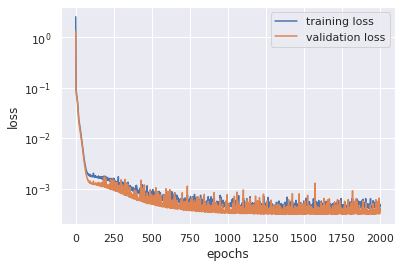

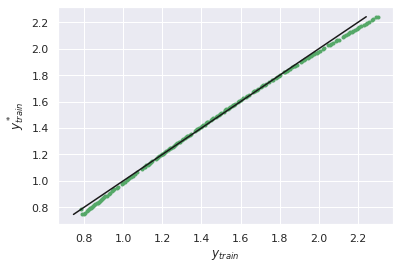

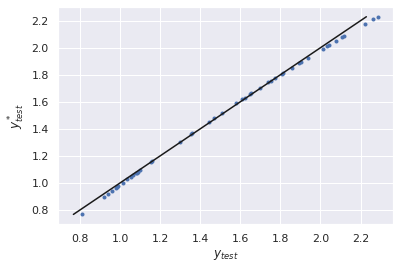

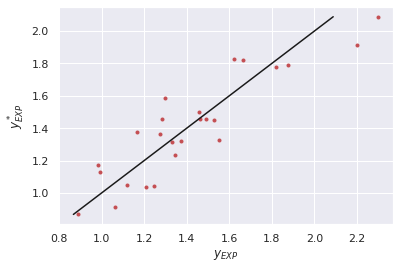

In [13]:
#Loss evaluation
plt.plot(history.history['mean_squared_error'], label = 'training loss')
plt.plot(history.history['val_mean_squared_error'], label = 'validation loss')
plt.yscale('log')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')

#TESTING
y_star_train = model.predict(X_train)
y_star_test = model.predict(X_test)
y_pred = model.predict(XE)

#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_star_test, 'b.')
plt.plot([y_star_test.min(), y_star_test.max()], [y_star_test.min(), y_star_test.max()], 'k')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')

plt.figure()
plt.plot(YE, y_pred, 'r.')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k')
plt.ylabel('$y^*_{EXP}$')
plt.xlabel('$y_{EXP}$')

from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_star_test)
MSE_train = mean_squared_error(y_train, y_star_train)
MSE_EXP = mean_squared_error(YE, y_pred)

print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print('MSE EXP:', MSE_EXP)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_star_test)
print('R2_test: ',R2_test)
R2_EXP=r2_score(YE, y_pred)
print('R2_EXP: ',R2_EXP)

RE=100 * abs(y_test - y_star_test) / y_test
print('Relative error (%): ',RE)
